In [1]:
import imports as i
import functions as f
import preprocessing as pp

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\MUSIC\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\MUSIC\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [ ]:
import neuralnetworks as nn

In [86]:
reload(f)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\MUSIC\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\MUSIC\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


<module 'functions' from 'D:\\ITU-BOOK\\2ndYearProject-NLP\\functions.py'>

In [74]:
PATH = {}
PATH["dataset_classification"] = "dataset/classification/"
PATH["dataset_labeling"] = "dataset/seq_labeling/"
PATH["music_reviews_train"] = PATH["dataset_classification"] + "music_reviews_train.json.gz"
PATH["music_reviews_dev"] = PATH["dataset_classification"] + "music_reviews_dev.json.gz"
PATH["music_reviews_test"] = PATH["dataset_classification"] + "music_reviews_test_masked.json.gz"
train = f.readJson(PATH["music_reviews_train"])
test = f.readJson(PATH["music_reviews_dev"])

Number of data:  100000
Number of data:  10000


In [75]:
X_train, y_train, train_idx, train_missing_idx = f.json_divide(train)
X_test, y_test, test_idx, test_missing_idx = f.json_divide(test)

In [76]:
# convert labels
sent_dict = {"positive": 1, "negative": 0}
y_train = pp.sentiment_converter(y_train, sent_dict)
y_test = pp.sentiment_converter(y_test, sent_dict)

In [77]:
# Tokenizer
tokenizer = pp.tokenizer_init(X_train, X_test)
Train = tokenizer.texts_to_sequences(X_train)
Test = tokenizer.texts_to_sequences(X_test)
# Sequencer 
X_train_p = pp.sequence_pad(Train) # there are several attributes which can be defined, basic = first 50 words 
X_test = pp.sequence_pad(Test)

In [78]:
# shitty sampling
X_train_p = X_train_p[1000:6000]
y_train = y_train[1000:6000]
X_test = X_test[1000:6000]
y_test = y_test[1000:6000]

In [110]:
def RNN_train(X_train_p, y_train, X_test, y_test, tokenizer, maxlen=50):
    import numpy as np
    # convert the sets into a numpy array
    X_train_p = np.array(X_train_p)
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    vocabulary_size = len(tokenizer.word_counts)
    
    from keras import Sequential
    from keras.layers import Embedding, LSTM, Dense, Dropout
    # get time if we want to saving the model
    dateTimeObj = i.datetime.now()
    save_time = str(dateTimeObj.year)+'-'+str(dateTimeObj.month)+'-'+str(dateTimeObj.day)+'-'+str(dateTimeObj.hour)+'-'+str(dateTimeObj.minute)+'-'+str(dateTimeObj.second)
    
    
    # define the model

    embedding_size=200 # bigger = slower train
    model=Sequential()
    model.add(Embedding(vocabulary_size+1, embedding_size, input_length=maxlen))
    model.add(LSTM(100))
    model.add(Dense(1, activation='tanh')) # shape of the labels, if its 2, than the y_ labels has a x* 2 shape
    
    model.compile(loss='binary_crossentropy', 
             optimizer='adam', 
             metrics=['accuracy'])

    #print(model.summary())
    
    # early stopping

    from keras.callbacks import ReduceLROnPlateau
    from keras.callbacks import EarlyStopping
    from keras.callbacks import ModelCheckpoint
    earlyStopping = EarlyStopping(monitor='val_accuracy', patience=1, verbose=1, mode='max',restore_best_weights=True)
    
    # activete this line, if you wanna save the best model: 
    # mcp_save = ModelCheckpoint('model/'+save_time+'-model.mdl_wts.hdf5', save_best_only=True, monitor='val_accuracy', mode='max')
    
    reduce_lr_loss = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=1, verbose=1, mode='min') 
    
    # patience: 10% of number of epochs. Anyway, it is just for stopping the validation, since we have model checkpoint its doesnt matter
    batch_size = 50 # lower = slower train, higher = faster train
    num_epochs = 10

    history = model.fit(X_train_p, y_train, validation_data=(X_test, y_test), 
                    batch_size=batch_size, 
                    epochs=num_epochs,
                    # callbacks=[earlyStopping, mcp_save, reduce_lr_loss]) # use this if you wanna save the model
                    callbacks=[earlyStopping, reduce_lr_loss])# for regularization)
    
    
    
    return history, model

In [111]:
history, model = RNN_train(X_train_p, y_train, X_test, y_test, tokenizer)

Epoch 1/10
100/100 [==============================] - 25s 234ms/step - loss: 0.8119 - accuracy: 0.6654 - val_loss: 0.6986 - val_accuracy: 0.5760 - lr: 0.0010
Epoch 2/10
100/100 [==============================] - ETA: 0s - loss: 0.4292 - accuracy: 0.8320
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
100/100 [==============================] - 23s 233ms/step - loss: 0.4292 - accuracy: 0.8320 - val_loss: 0.4445 - val_accuracy: 0.8254 - lr: 0.0010
Epoch 3/10
100/100 [==============================] - ETA: 0s - loss: 0.1833 - accuracy: 0.9426
Epoch 3: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
100/100 [==============================] - 23s 228ms/step - loss: 0.1833 - accuracy: 0.9426 - val_loss: 0.4552 - val_accuracy: 0.8392 - lr: 2.0000e-04
Epoch 4/10
100/100 [==============================] - ETA: 0s - loss: 0.1417 - accuracy: 0.9590
Epoch 4: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.
100/100 [=================

# BASELINE NN FUNCTION

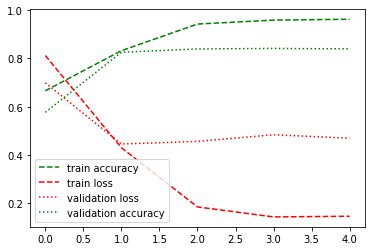

In [113]:
f.plot_model_history(history)

In [114]:
result = i.np.round(model.predict(X_test))
i.accuracy_score(y_test, result)

0.8414

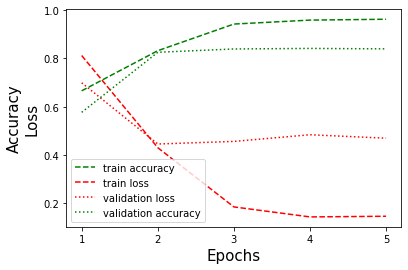

In [200]:
plot_model_history(history)

In [117]:
import matplotlib.pyplot as plt

In [124]:
history.history["accuracy"]

[0.6654000282287598,
 0.8320000171661377,
 0.9426000118255615,
 0.9589999914169312,
 0.9625999927520752]

In [131]:
x = range(1,10)

In [132]:
x

range(1, 10)

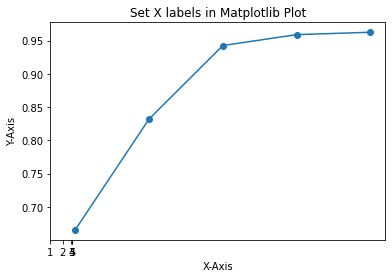

In [158]:
len(history.history["accuracy"])

5

range(0, 5)


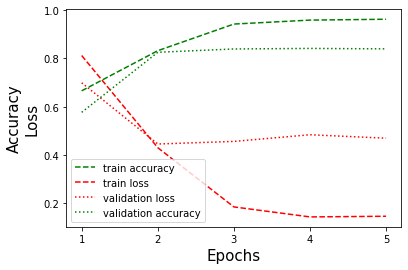

In [198]:
    x = range(0,len(history.history["accuracy"]))
    labels = range(1,len(history.history["accuracy"])+1)
    plt.xticks(x, labels)
    plt.plot(history.history["accuracy"], 'g--', label='train accuracy')
    plt.plot(history.history["loss"], 'r--', label='train loss')
    plt.plot(history.history["val_loss"], 'r:', label='validation loss')
    plt.plot(history.history["val_accuracy"], 'g:', label='validation accuracy')
    plt.legend()
    plt.xlabel('Epochs', fontsize=15, color='black')
    plt.ylabel('Accuracy\nLoss', fontsize=15, color='black')
    plt.show()